## Telecom Customer Churn:
     Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

#### Content:
     Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

#### The data set includes information about:

   * Customers who left within the last month – the column is called Churn
   * Services that each customer has signed up for – phone, multiple lines, internet, online        * security, online backup, device protection, tech support, and streaming TV and movies
   * Customer account information – how long they’ve been a customer, contract, payment method, 
   * paperless billing, monthly charges, and total charges
   * Demographic info about customers – gender, age range, and if they have partners and dependents
   * Churn - dependent feature ('Yes' denotes customers left, 'No' denotes customer stay here)
   
   Dataset taken from Kaggle: https://www.kaggle.com/blastchar/telco-customer-chur
     

In [1]:
# Importing neccessary packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter

# ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # for showing percentage in it

In [3]:
data = pd.read_csv('data/Telco-Customer-Churn.csv')
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Features types
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### From analysis the dataset, we notice that some of the independent features are in numerical and most of feature are in categorical feature. Seperate into numerical and categorical data for EDA parts**

In [5]:
# Total charges are in object dtype so convert into Numerical feature
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

#### Separate into Numerical and Categorical feature

In [6]:
# numerical feature
numerical_feature = {feature for feature in data.columns if data[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(f'Numerical feature are:\n {numerical_feature}')

Count of Numerical feature: 4
Numerical feature are:
 {'tenure', 'SeniorCitizen', 'TotalCharges', 'MonthlyCharges'}


In [7]:
# Categorical feature
categorical_feature = {feature for feature in data.columns if data[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(f'Categorical feature are:\n {categorical_feature}')

Count of Categorical feature: 16
Categorical feature are:
 {'MultipleLines', 'TechSupport', 'InternetService', 'PaperlessBilling', 'DeviceProtection', 'Contract', 'PhoneService', 'PaymentMethod', 'Partner', 'Churn', 'gender', 'OnlineSecurity', 'StreamingTV', 'StreamingMovies', 'OnlineBackup', 'Dependents'}


## EDA

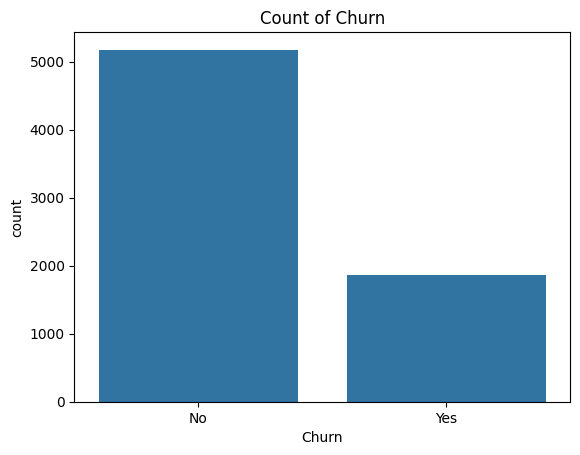

In [8]:
# plotting with target feature
sns.countplot(data=data, x='Churn')
plt.title('Count of Churn')
plt.show()

In [9]:
l1 = data.loc[data['Churn']== 'Yes'].count()[0]
print(f"Pecentage of Left: {l1/len(data['Churn'])}")
print(data.Churn.value_counts())

Pecentage of Left: 0.2653698707936959
Churn
No     5174
Yes    1869
Name: count, dtype: int64


**1869 of customer are left about 26.5 percentage from overall, this like an imbalance dataset**

In [10]:
### How much amount loss from customer churn of 26%
loss = []
for values in data.loc[data['Churn'] == 'Yes', 'TotalCharges']:
    value = float(values)
    loss.append(value)
print(np.round(sum(loss)))

2862927.0


**We have lost arround $2862927 due to customer churn**

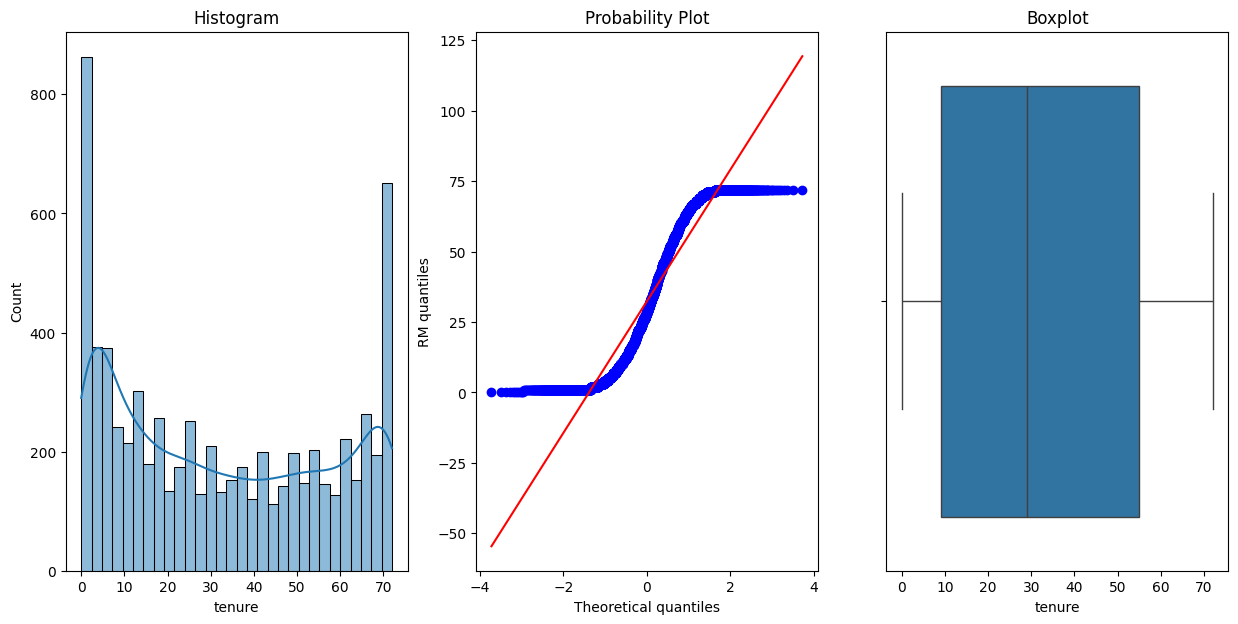

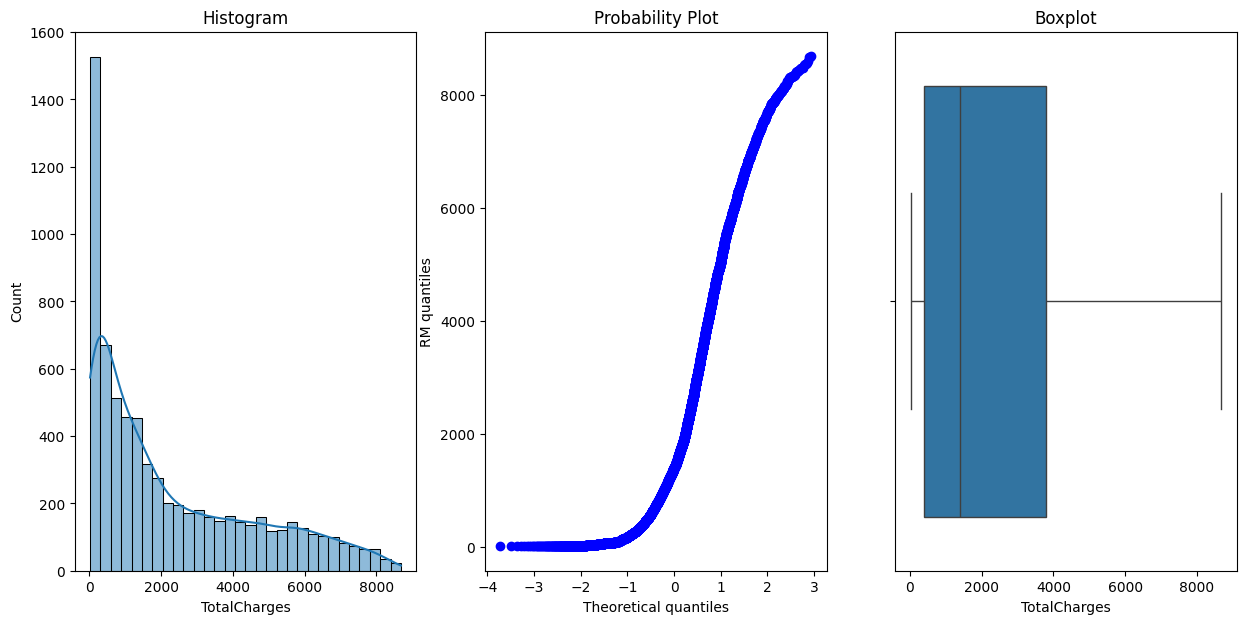

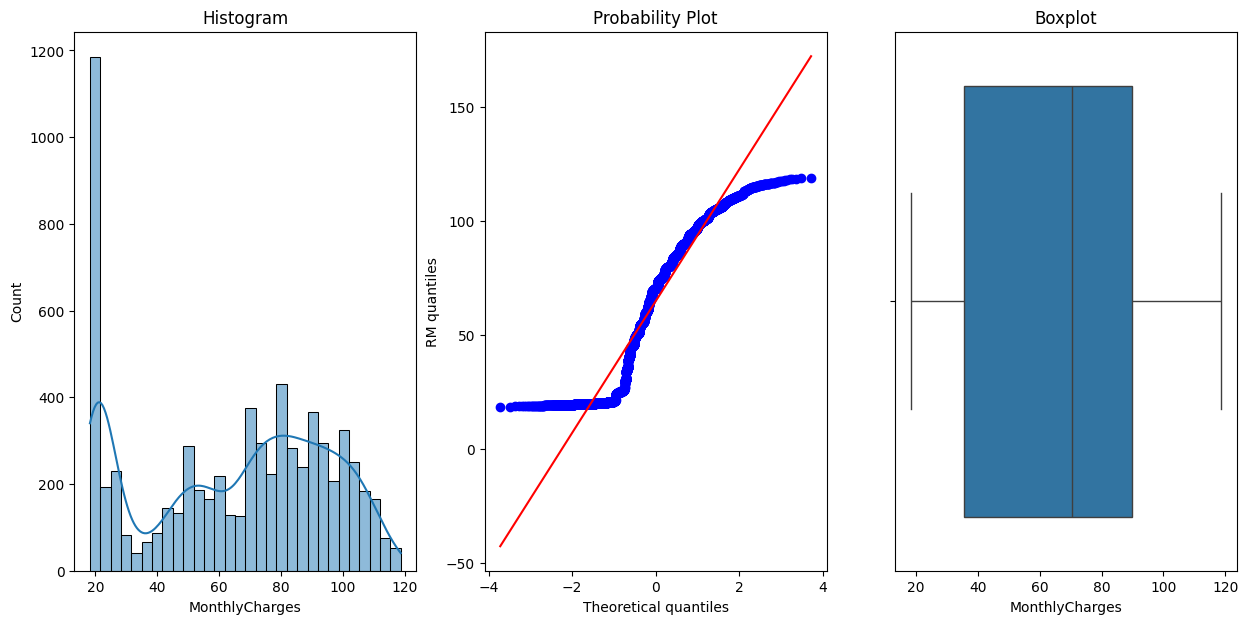

In [11]:
### Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(15,7))
    
        plt.subplot(1, 3, 1)
        sns.histplot(data=data, x=feature, bins=30, kde=True)
        plt.title('Histogram')
    
        plt.subplot(1, 3, 2)
        stats.probplot(data[feature], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')
    
        plt.subplot(1, 3, 3)
        sns.boxplot(x=data[feature])
        plt.title('Boxplot')
    
plt.show()

##### **After ploting histogram probability distribution and box plot to find numerical value are in normally distribution and our dataset has no outlier dataset.So, we don't want to remove the outlier in our dataset**

Text(0.5, 1.0, '% of Senior Citizens')

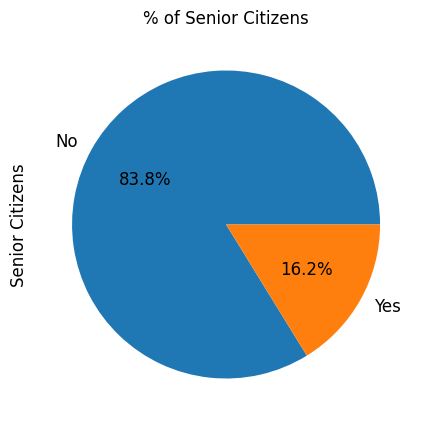

In [12]:
# pie chart for Count of Senior citizens
ax = (data['SeniorCitizen'].value_counts()*100.0 /len(data)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

##### **Only 16.2% customers who are senior citizons but remaining 83.8% customers are young people**

#### **Univariate Analysis:**

<Figure size 640x480 with 0 Axes>

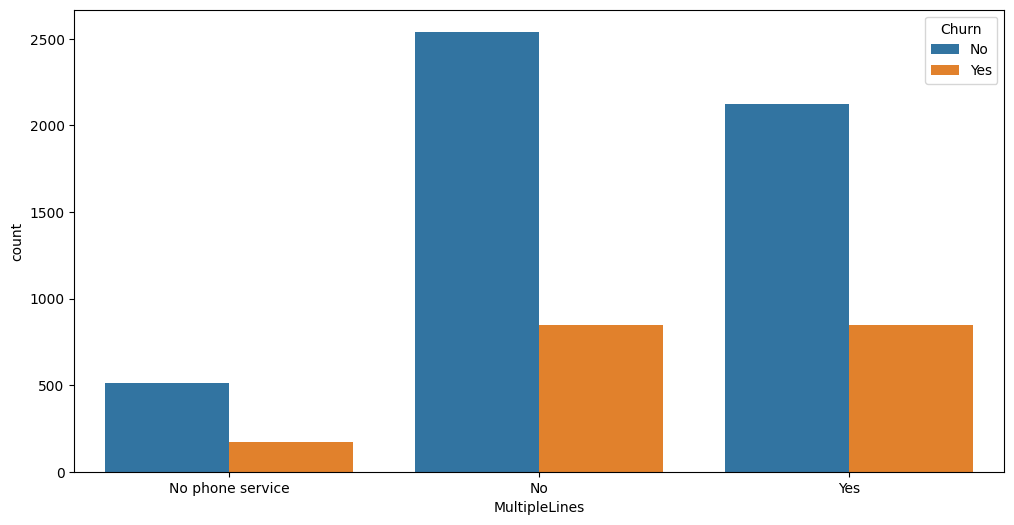

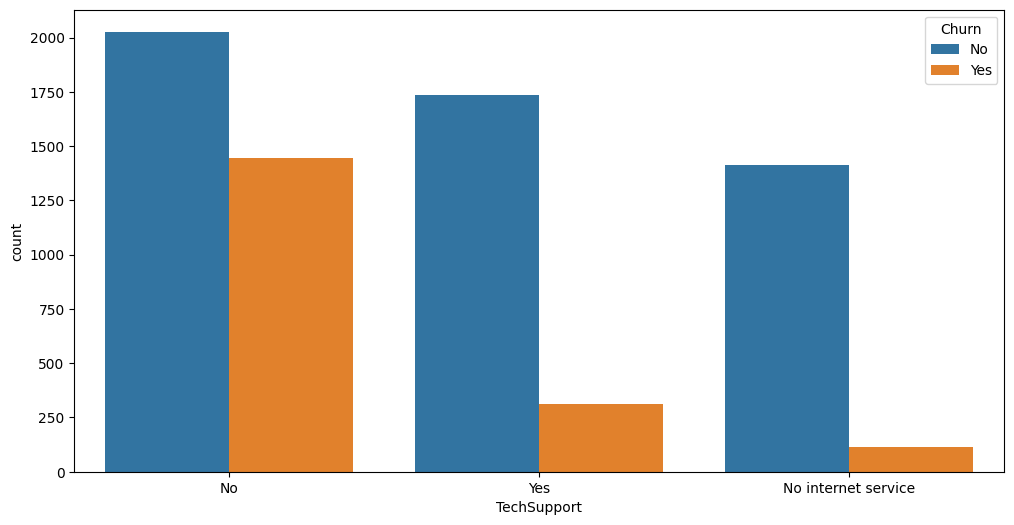

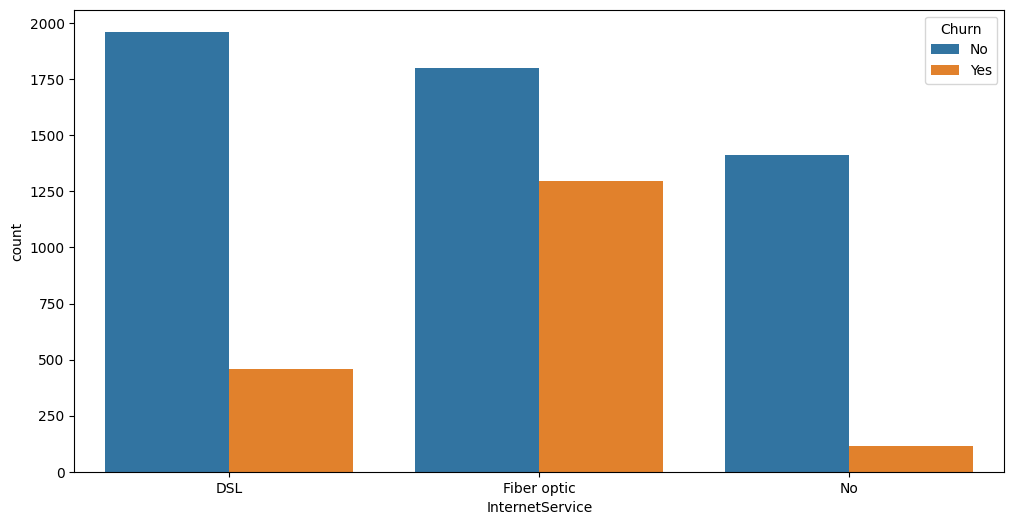

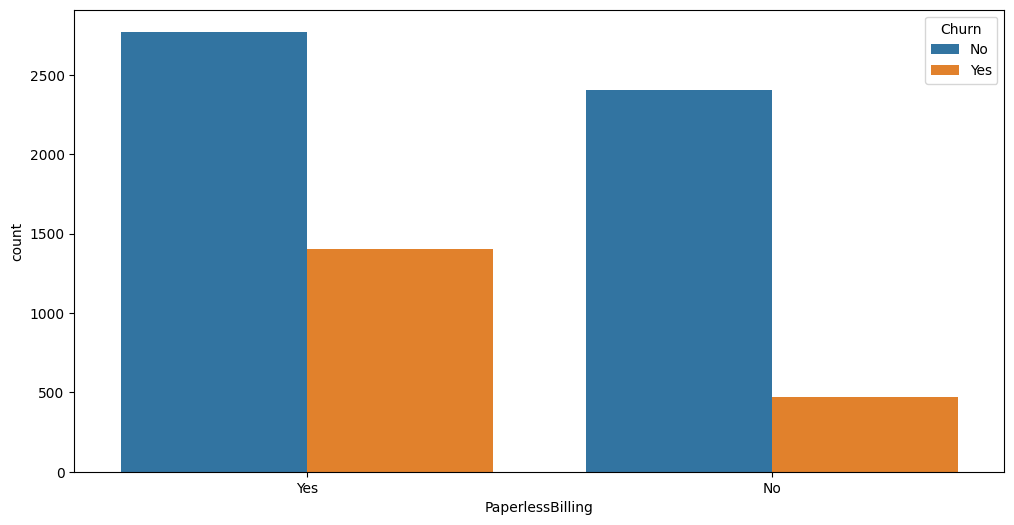

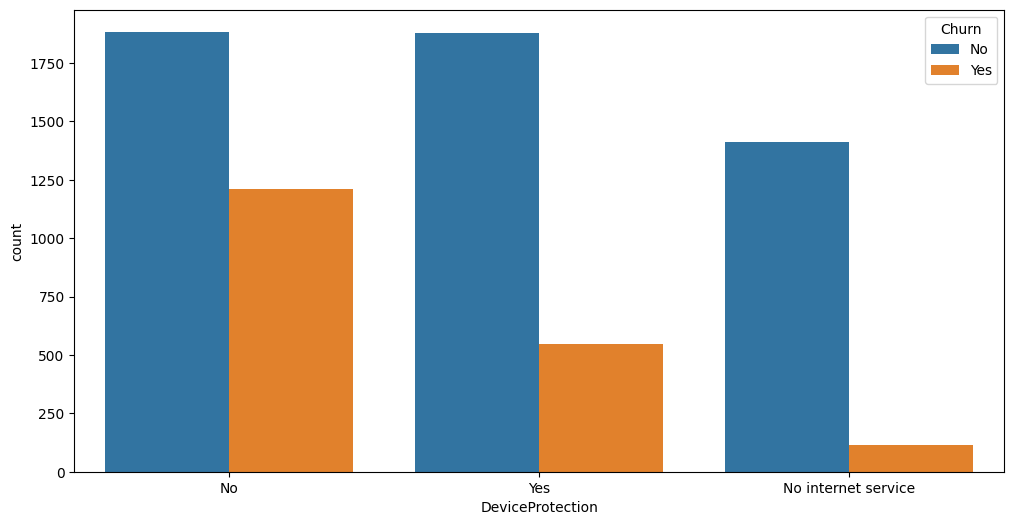

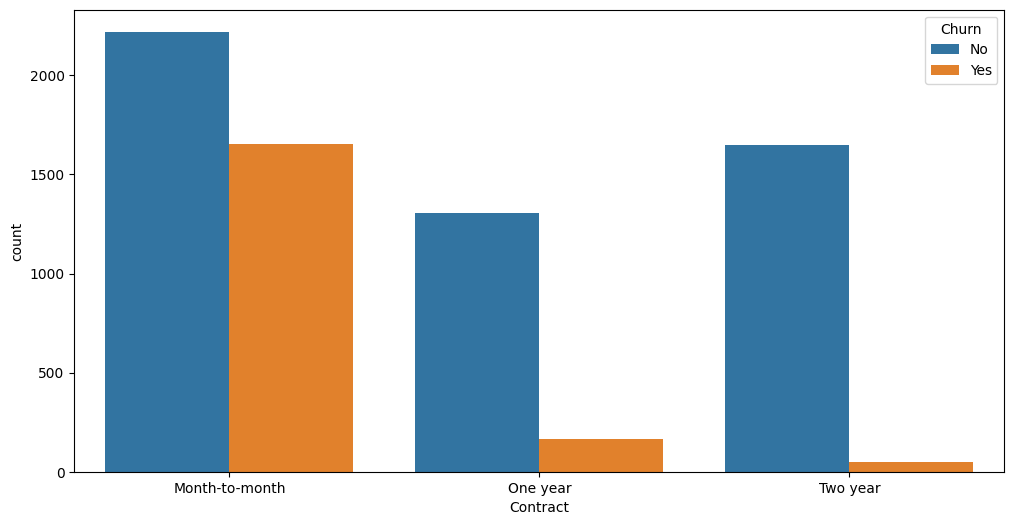

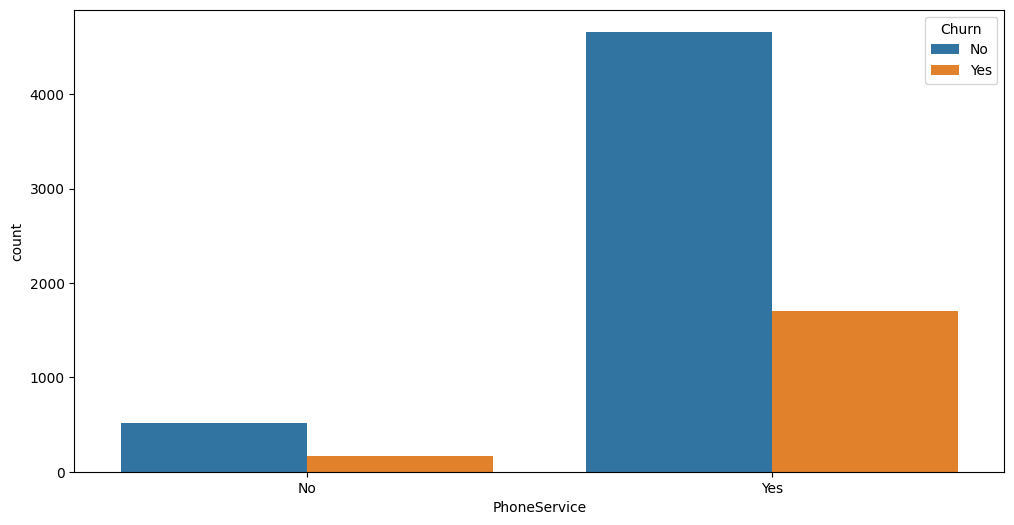

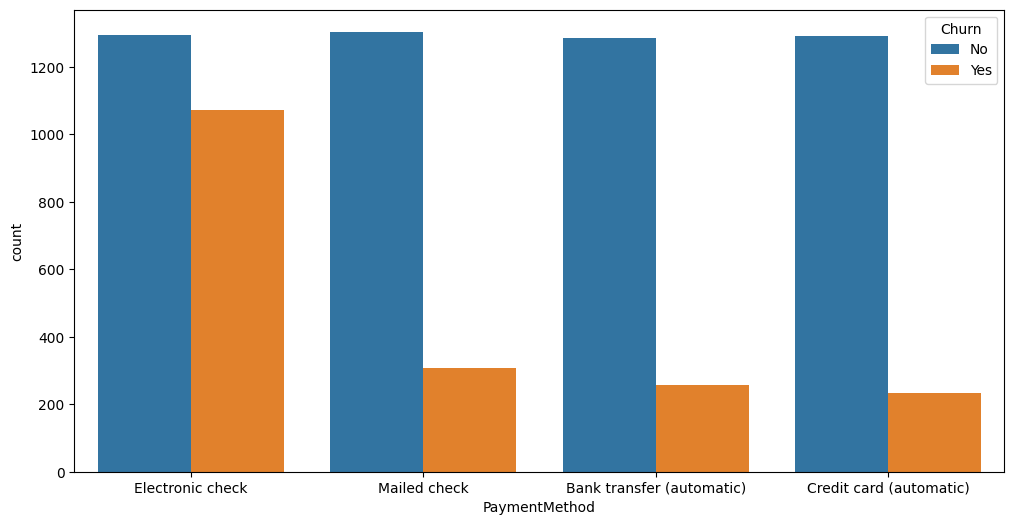

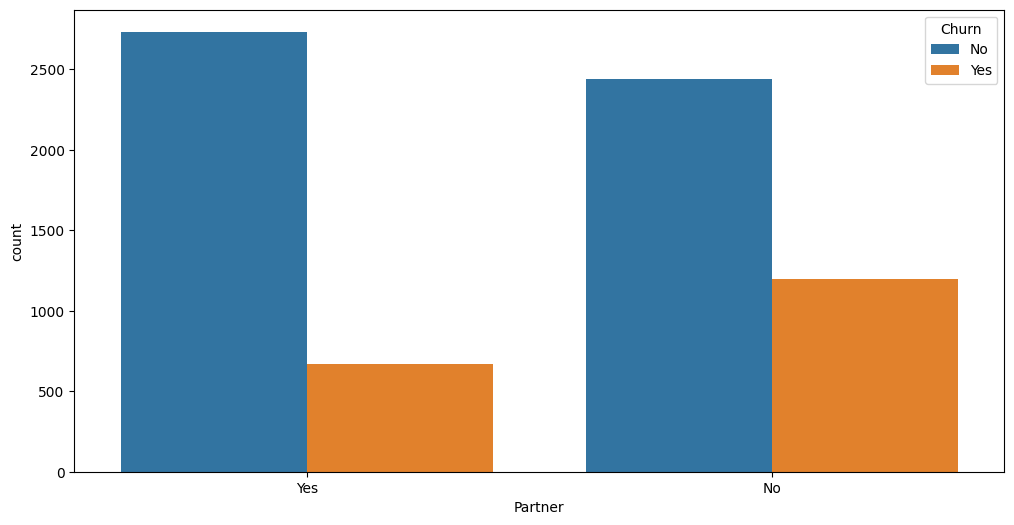

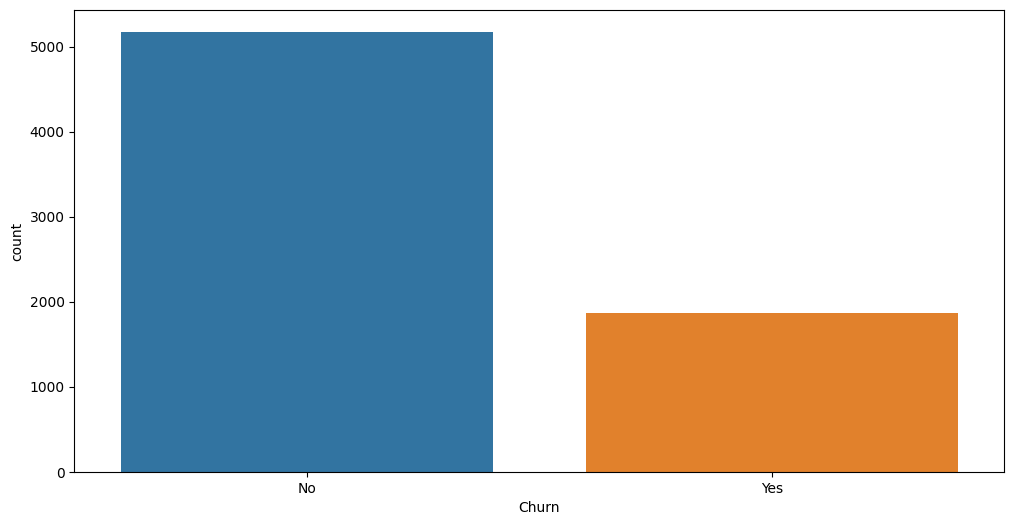

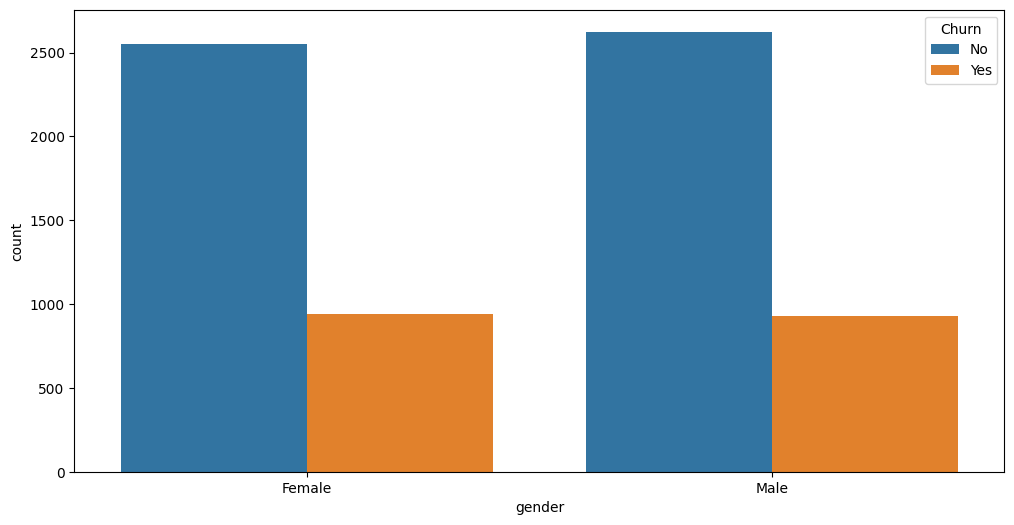

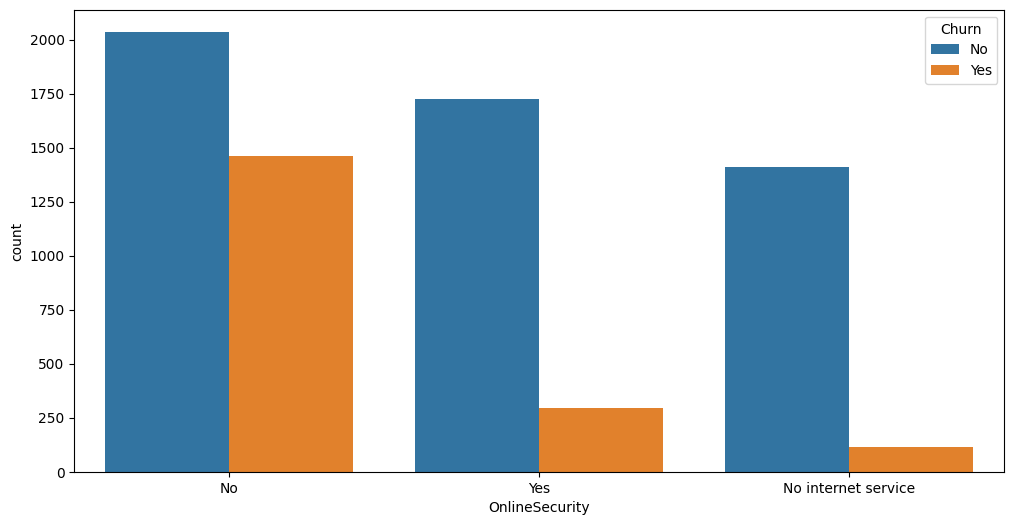

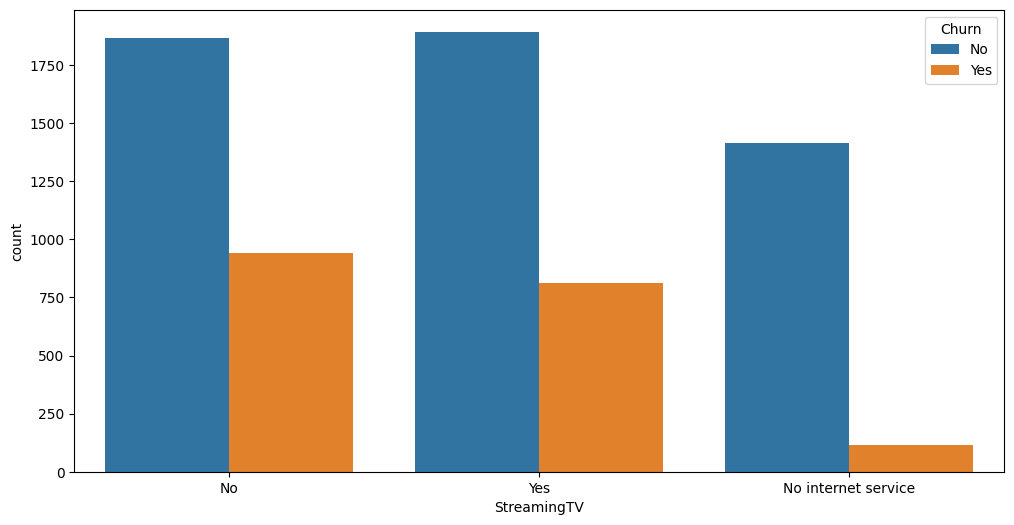

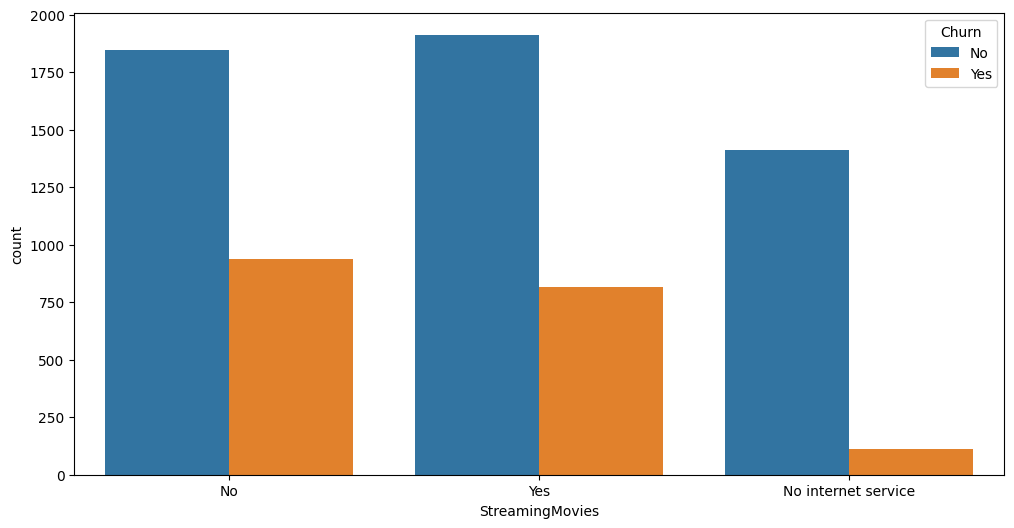

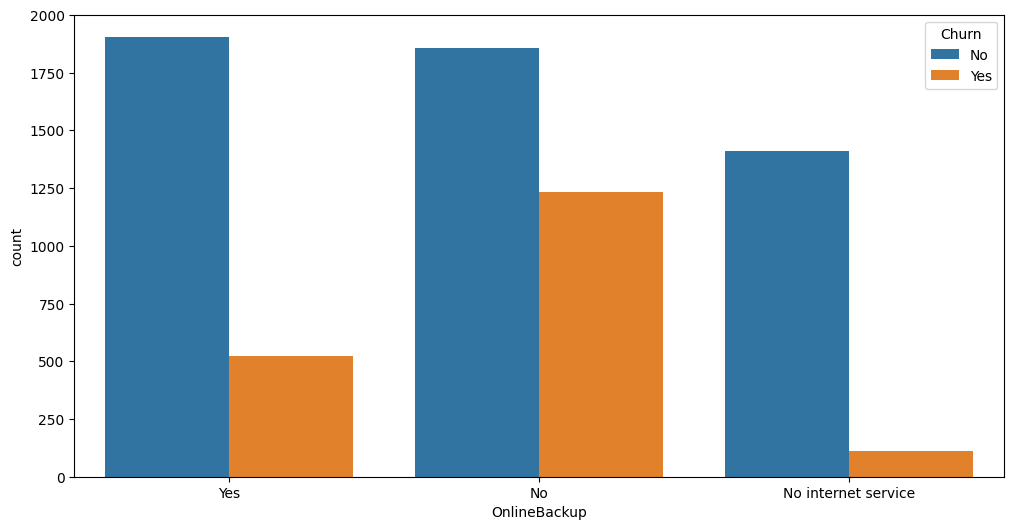

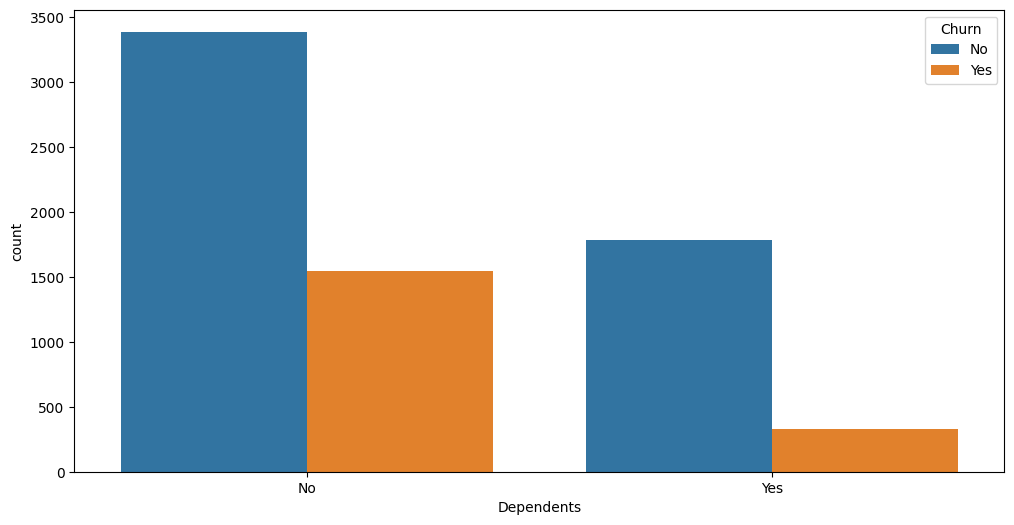

In [13]:
for i, feature in enumerate(categorical_feature):
    if feature != 'TotalCharges':
        if feature != 'customerID':
            plt.figure(i)
            plt.figure(figsize=(12,6))
            sns.countplot(data=data, x=feature, hue='Churn')
plt.show()

#### **Data Cleaning:**

In [14]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [16]:
# replace NaN values with median value
data.TotalCharges = data.TotalCharges.fillna(data.TotalCharges.median())

<Axes: >

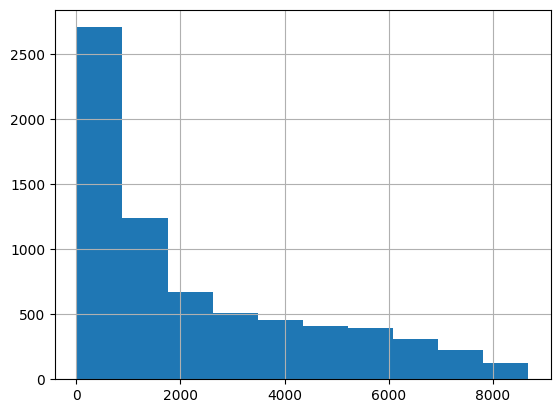

In [17]:
data.TotalCharges.hist()

##### **In this dataset there is no null values, so we dont want to perform Handling missing values. Only perform the Feature Encoding techiniques to convert the categorical feature into numerical feature**

In [18]:
print(categorical_feature)

{'MultipleLines', 'TechSupport', 'InternetService', 'PaperlessBilling', 'DeviceProtection', 'Contract', 'PhoneService', 'PaymentMethod', 'Partner', 'Churn', 'gender', 'OnlineSecurity', 'StreamingTV', 'StreamingMovies', 'OnlineBackup', 'Dependents'}


In [19]:
#### Apply label encoding to convert categorical to numerical values

In [20]:
encoder = LabelEncoder()
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature])

In [21]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


#### Dropping customer ID , as it is not important for model prediction

In [22]:
data.drop(columns=['customerID'], inplace=True)

KeyError: "['customerID'] not found in axis"

<Axes: >

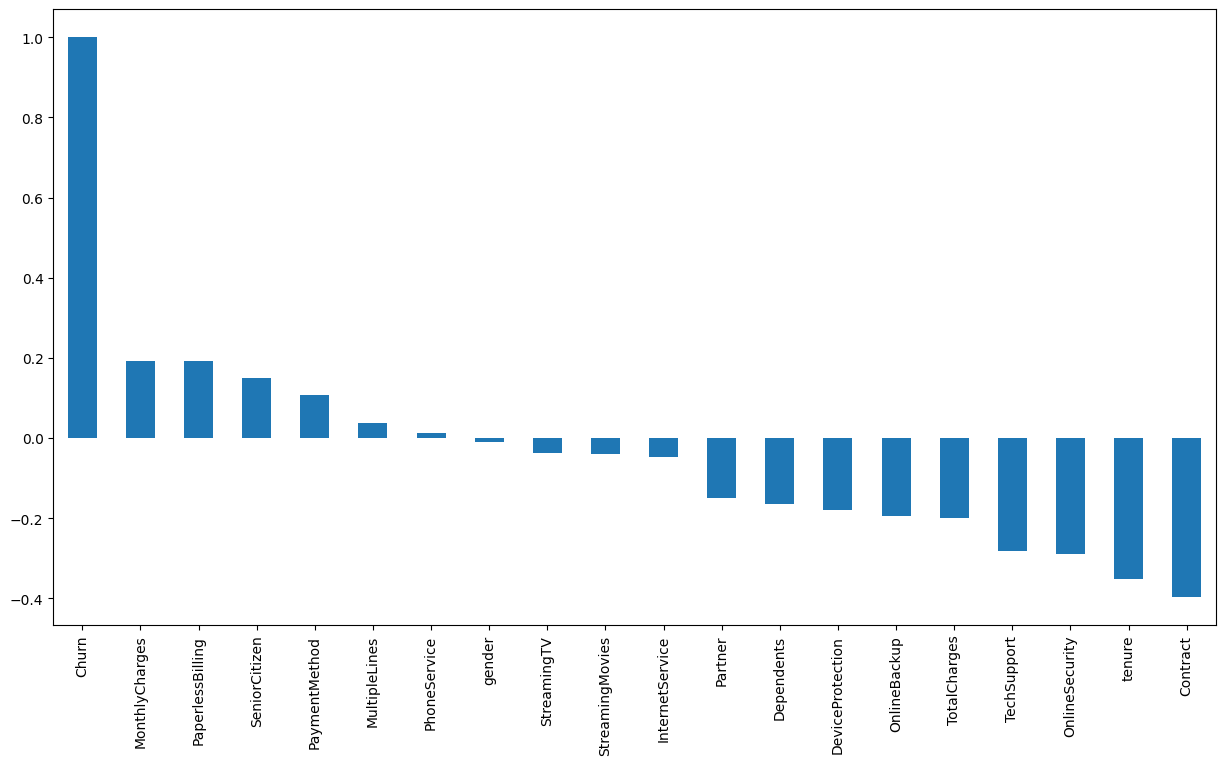

In [22]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

<Axes: >

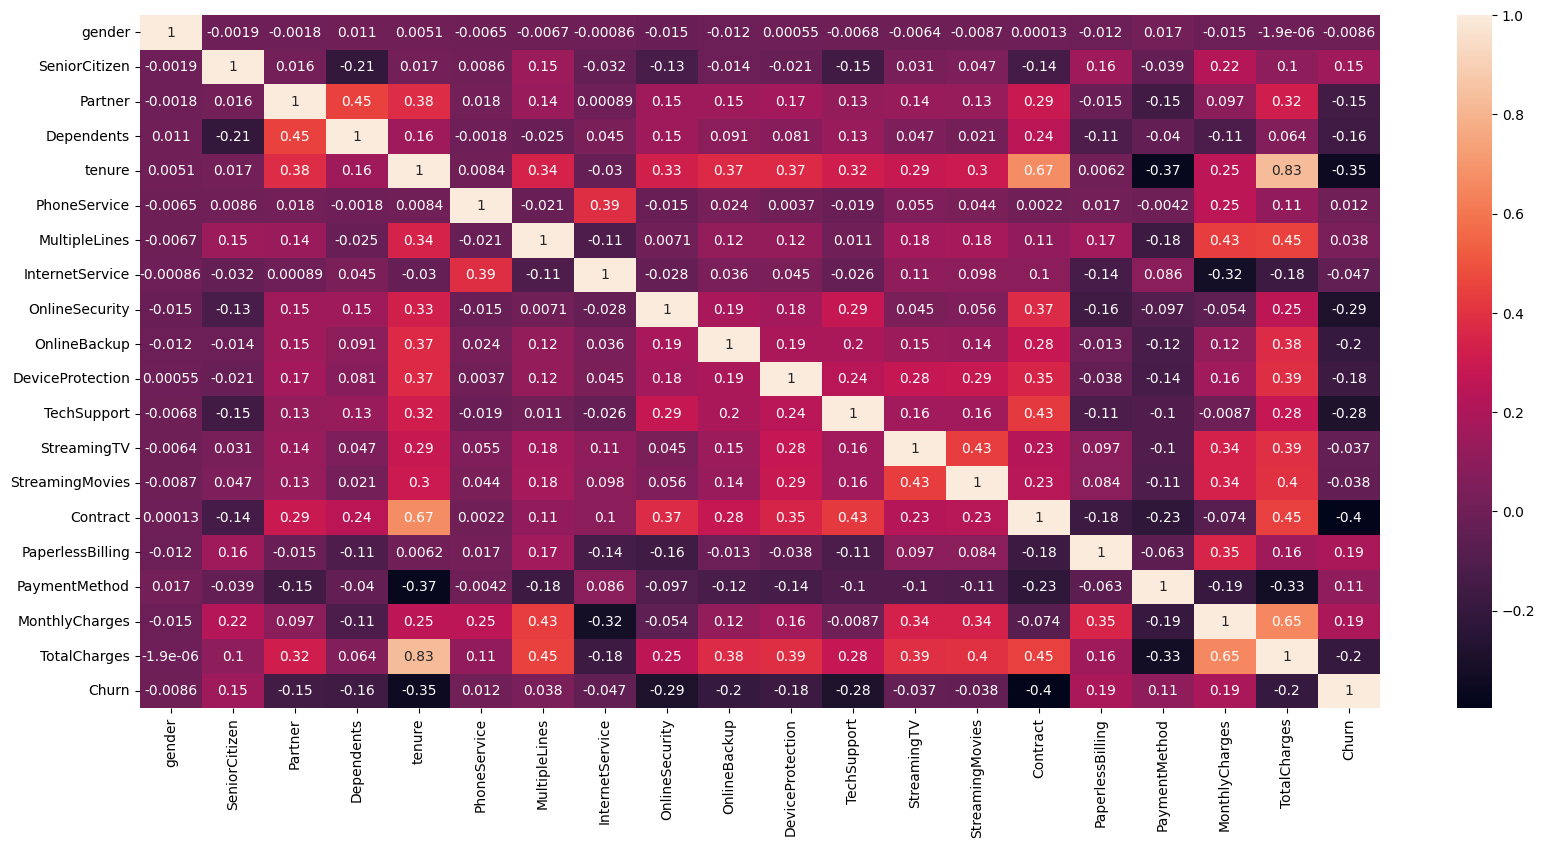

In [23]:
# Finding the correlation between the independent and dependent feature
plt.figure(figsize=(20, 9))
sns.heatmap(data.corr(), annot=True)

**Iam using ensemble methods, No need to perform feature scaling for ensemble techniques, its prediction based on the creating multiple decision trees**

#### Splitting the dataset into train and test

In [23]:
# splitting dataset into dependent and independent feature
X = data.drop(columns='Churn')
y = data['Churn']

In [24]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65


In [25]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

#### Feature Selection:
     Selects only 10 feature which has higher correlation

In [26]:
# selects the feature which has more correlation
selection = SelectKBest()  # k=10 default
X = selection.fit_transform(X,y)

In [27]:
#  this will shows which feature are taken denote as True other are removed like false
selection.get_support()

array([False, False, False,  True,  True, False, False, False,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True])

**According to the feature selection, we selects the 10 out of 21 features. these are the 10 features are selected [Dependents, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges, TotalCharges]**

##### **From sklearn using feature selection modules importing the SelectKBest to select the important feature**

In [28]:
# splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
X_train.shape

(5634, 10)

In [30]:
X_test.shape

(1409, 10)

In [31]:
# its an imbalance dataset
y.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

#### **Apply into machine learning algorithm:**

In [32]:
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.7977288857345636
Confusion matrix :
 [[920 162]
 [123 204]]
Classification report :
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      1082
           1       0.56      0.62      0.59       327

    accuracy                           0.80      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.81      0.80      0.80      1409



In [33]:
# Random forest classifier
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.7970191625266146
Confusion matrix :
 [[956 199]
 [ 87 167]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      0.83      0.87      1155
           1       0.46      0.66      0.54       254

    accuracy                           0.80      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.83      0.80      0.81      1409



In [34]:
# decisionTree Classifier
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7906316536550745
Confusion matrix :
 [[949 201]
 [ 94 165]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      1150
           1       0.45      0.64      0.53       259

    accuracy                           0.79      1409
   macro avg       0.68      0.73      0.70      1409
weighted avg       0.83      0.79      0.80      1409



**As we compare to the imbalance dataset our model are perform like okay not a better model to build for end to end project. So we need to over smpling data for reducing the TN, FN and increase the FP and TP for model building**

#### Using SMOTEENN for imbalance dataset: Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [35]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 4131, 1: 1503})
The number of classes after fit Counter({1: 2522, 0: 2170})


In [36]:
# splitting the over sampling dataset 
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [37]:
# decisionTree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9201277955271565
Confusion matrix :
 [[371  26]
 [ 49 493]]
Classification report :
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       397
           1       0.95      0.91      0.93       542

    accuracy                           0.92       939
   macro avg       0.92      0.92      0.92       939
weighted avg       0.92      0.92      0.92       939



In [38]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9297124600638977
Confusion matrix :
 [[376  22]
 [ 44 497]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       398
           1       0.96      0.92      0.94       541

    accuracy                           0.93       939
   macro avg       0.93      0.93      0.93       939
weighted avg       0.93      0.93      0.93       939



In [39]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.9137380191693291
Confusion matrix :
 [[364  25]
 [ 56 494]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       389
           1       0.95      0.90      0.92       550

    accuracy                           0.91       939
   macro avg       0.91      0.92      0.91       939
weighted avg       0.92      0.91      0.91       939



In [40]:
# AdaboostBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(X_train_sap, y_train_sap)
pred = abc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9105431309904153
Confusion matrix :
 [[362  26]
 [ 58 493]]
Classification report :
               precision    recall  f1-score   support

           0       0.86      0.93      0.90       388
           1       0.95      0.89      0.92       551

    accuracy                           0.91       939
   macro avg       0.91      0.91      0.91       939
weighted avg       0.91      0.91      0.91       939



In [41]:
import xgboost
from xgboost import XGBClassifier
# XGBoostingClassifier
xgb = XGBClassifier()
xgb.fit(X_train_sap, y_train_sap)
pred = xgb.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')


Accuracy score : 0.9605963791267306
Confusion matrix :
 [[397  14]
 [ 23 505]]
Classification report :
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       411
           1       0.97      0.96      0.96       528

    accuracy                           0.96       939
   macro avg       0.96      0.96      0.96       939
weighted avg       0.96      0.96      0.96       939



In [42]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9456869009584664
Confusion matrix :
 [[383  14]
 [ 37 505]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       397
           1       0.97      0.93      0.95       542

    accuracy                           0.95       939
   macro avg       0.94      0.95      0.94       939
weighted avg       0.95      0.95      0.95       939



**After using SMOOTEENN methods to perform over sampling and down sampling with edited nearest neighbours. From this results we get better accuraccy and TP FP ratio also increases in GradientBoostClassifier so perform HyperParameter Tunning for this model only**

In [43]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],
             'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [45]:
gbc_optm = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid,n_iter=100, verbose=3)
gbc_optm.fit(X_train_sap, y_train_sap)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=mae, learning_rate=0.2, loss=exponential, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=250;, score=nan total time=   0.0s
[CV 2/5] END criterion=mae, learning_rate=0.2, loss=exponential, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END criterion=mae, learning_rate=0.2, loss=exponential, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END criterion=mae, learning_rate=0.2, loss=exponential, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=250;, score=nan total time=   0.0s
[CV 5/5] END criterion=mae, learning_rate=0.2, loss=exponential, max_depth=9, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=250;, score=nan total time=   0.0s
[CV 1/5

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_leaf_nodes': [3, 6, 8, 9, 12, 15,
                                                           18, 24],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   verbose=3)

In [46]:
gbc_optm.best_estimator_

GradientBoostingClassifier(learning_rate=0.5, loss='exponential', max_depth=9,
                           max_leaf_nodes=12, min_samples_leaf=7,
                           min_samples_split=9, n_estimators=200)

In [47]:
# GradientBoostingClassifier
gbc_tunning = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.4,loss='exponential',
                           max_depth=19, max_leaf_nodes=9, min_samples_leaf=3,
                           min_samples_split=8, n_estimators=300)
gbc_tunning.fit(X_train_sap, y_train_sap)
pred = gbc_tunning.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9709051724137931
Confusion matrix :
 [[432   5]
 [ 22 469]]
Classification report :
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       437
           1       0.99      0.96      0.97       491

    accuracy                           0.97       928
   macro avg       0.97      0.97      0.97       928
weighted avg       0.97      0.97      0.97       928



**After Oversampling the dataset our model performs is pretty good. From our 4 model GradientBoostClassifier performs better than all. So we dumb our model using pickle library**

In [48]:
'''
## Hyper param tunning for XGBoost
# XGBoost parameters for hyperparameter tuning
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
    "max_depth": [3, 5, 7],  # Maximum depth of a tree
    "n_estimators": [50, 100, 200],  # Number of boosting rounds
    "subsample": [0.6, 0.8, 1.0],  # Fraction of samples used for training
    "colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features used per tree
    "gamma": [0, 0.1, 0.2],  # Minimum loss reduction required for a split
    "reg_alpha": [0, 0.1, 1],  # L1 regularization
    "reg_lambda": [1, 1.5, 2],  # L2 regularization}
    '''


'\n## Hyper param tunning for XGBoost\n# XGBoost parameters for hyperparameter tuning\nxgb_params = {\n    "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage\n    "max_depth": [3, 5, 7],  # Maximum depth of a tree\n    "n_estimators": [50, 100, 200],  # Number of boosting rounds\n    "subsample": [0.6, 0.8, 1.0],  # Fraction of samples used for training\n    "colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features used per tree\n    "gamma": [0, 0.1, 0.2],  # Minimum loss reduction required for a split\n    "reg_alpha": [0, 0.1, 1],  # L1 regularization\n    "reg_lambda": [1, 1.5, 2],  # L2 regularization}\n    '

In [49]:
#xgb_optm = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params,n_iter=100, verbose=3)
#xgb_optm.fit(X_train_sap, y_train_sap)